Importing modules

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xmitgcm
import os
from cmocean import cm

Defining the path for the input folder

In [2]:
path = os.path.join(os.getcwd(),'../input/')

## Bathymetry

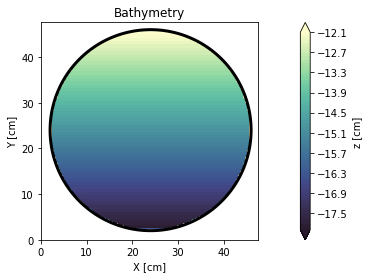

In [70]:
# define dx, NX and Ny
dx = 0.004
NX,NY = 120,120
x,y = np.meshgrid(np.arange(0,NX*dx,dx),np.arange(0,NY*dx,dx))

dh = 6e-2 # depth variation
mh = -0.15 # mean depth

# bathymetry
bat = y*(dh/(0.44)) 
bat = bat-bat.mean()+mh

# radii from the center
rs = np.sqrt((y-NY*dx/2)**2+(x-NX*dx/2)**2)*1e2
# angles
thetas = np.arctan2((y-NY*dx/2),(x-NX*dx/2))

# mask of the tank (radius = 22cm)
bat[rs>=22] = 0

# create the figure
kw = {
    'bat':{
        'levels':np.arange(-18,-12,0.1),
        'cmap':cm.deep_r,
        'extend':'both',
    },
    'mask':{
        'levels':[-1e-10,1e10],
        'colors':'w',
    },
    'radii':{
        'levels':[22],
        'colors':'k',
        'linewidths':3,
    },
    'ax':{
        'title':'Bathymetry',
        'xlabel':'X [cm]',
        'ylabel':'Y [cm]',
    },
}

fig, ax = plt.subplots()

C = ax.contourf(x*1e2,y*1e2,bat*1e2,**kw['bat']) #plot the bathymetry data
ax.contourf(x*1e2,y*1e2,bat*1e2,**kw['mask']) # masking 0 values in white
ax.contour(x*1e2,y*1e2,rs,**kw['radii']) # plot the line for the tank radius

cbar = fig.colorbar(C)
cbar.set_label('z [cm]')
ax.set(**kw['ax'])
_ = ax.axis('scaled')

## Wind Stress

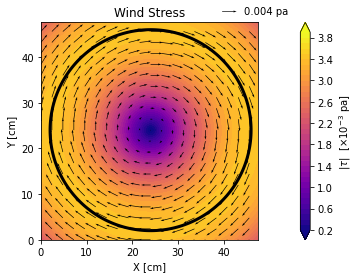

In [102]:
Cd = 1.25e-3 # Drag coefficient
rhoair = 1 # Air density
u0 = 1.66 # Wind velocity (converted from 39CFM of the computer coolers)
W = rhoair*Cd*u0**2 # Wind amplitude
L = 2*44 # Diameter of the tank

# Getting the tangencial stress
tau = W*np.sin(2*np.pi*rs/L)

# Convert to Taux and Tauy
tau = tau*np.exp(1j*thetas)
taux = tau.imag
tauy = -tau.real


kw = {
    'tau':{
        'levels':np.arange(0.2,4,0.1),
        'cmap':'plasma',
        'extend':'both',
        'antialiased':False,
    },
    'quiver':{
        'scale':60,
    },
    'radii':{
        'levels':[22],
        'colors':'k',
        'linewidths':3,
    },
    'ax':{
        'title':'Wind Stress',
        'xlabel':'X [cm]',
        'ylabel':'Y [cm]',
    },
}

skip=(slice(None,None,6),slice(None,None,6))

fig, ax = plt.subplots()
C = ax.contourf(x*1e2,y*1e2,np.abs(tau)*1e3,**kw['tau'])
Q = ax.quiver(x[skip]*1e2,y[skip]*1e2,
          taux[skip]*1e3,tauy[skip]*1e3,**kw['quiver'])
ax.quiverkey(Q,0.9,1.05,4,'0.004 pa',labelpos='E')
ax.contour(x*1e2,y*1e2,rs,**kw['radii'])
cbar = fig.colorbar(C)
cbar.set_label('$|\\tau|$  [$\\times$10$^{-3}$ pa]')
ax.set(**kw['ax'])
_ = ax.axis('scaled')

## Saving data

In [40]:
xmitgcm.utils.write_to_binary(taux.flatten(), path+'utau.bin',dtype='float64')
xmitgcm.utils.write_to_binary(tauy.flatten(), path+'vtau.bin',dtype='float64')
xmitgcm.utils.write_to_binary(bat.flatten(), path+'bathy.bin',dtype='float64')